## Dataset show

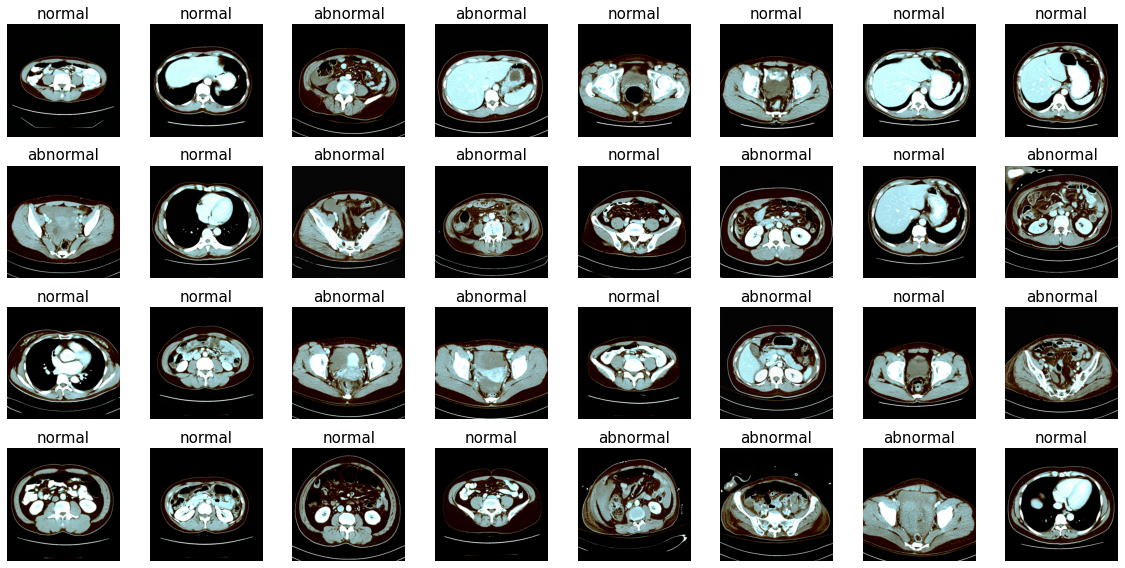

In [6]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm


# Using CrossEntropy loss
class BodyDataset(Dataset): 
    def __init__(self, df, transform=None, standardization=False):
        self.df = df
        self.classes = ('normal', 'abnormal')
        self.transform = transform
        self.standardization = standardization

    @staticmethod
    def reshape_image(img):
        return np.expand_dims(img, axis=0)
    
    def load_image(self, img_path):
        img = np.array(Image.open(img_path))
        if img.ndim == 2:
            img = BodyDataset.reshape_image(img)
        else:
            img = np.transpose(img, (2,0,1))

        img = torch.from_numpy(np.array(img, dtype=np.float32) / 255.)
        
        if self.standardization:
            img = transforms.Normalize([0.2096, 0.2226, 0.2109], [0.2953, 0.3468, 0.3482])(img)
            # img = transforms.Normalize([0.2088], [0.2965])(img)
            # img = transforms.Normalize([0.2242], [0.3448])(img)

        if self.transform:
            img = self.transform(img)

        return img
    

    def __getitem__(self, index):
        img = self.load_image(self.df.iloc[index][0])
        label = torch.LongTensor([self.df.iloc[index][1]])
        return [img, label]
        
    def __len__(self):
        return len(self.df)


train_ds = BodyDataset(pd.read_csv('3channel_train.csv'), standardization=False)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

# Showing 8 columns of grid image
def show_img(img:torch.tensor, label:torch.tensor=None): 
    img = img.permute(0,2,3,1)
    img = img.detach().cpu().numpy()
    img = np.array(img*255, dtype=np.uint8)
    
    plt.figure(figsize=(16, img.shape[0]//4))
    for i in range(img.shape[0]):
        plt.subplot(img.shape[0]//8, 8, i+1)
        plt.axis('off')

        if 'label' in locals():
            title = label[i].cpu().numpy()[0]
            title = train_ds.classes[title]
            plt.title(title, {'fontsize': 15})

        if img[i].shape[2] == 1:
            plt.imshow(img[i], cmap='gray')
        else:
            plt.imshow(img[i])
    
    plt.tight_layout()
    plt.show()


x, y = next(iter(train_loader))
show_img(x, y)

## Data Distribution

In [7]:
count = len(train_ds) * 512 * 512
psum = torch.FloatTensor([0,0,0])
psum_sq = torch.FloatTensor([0,0,0])

for x, _ in tqdm(train_loader):
    psum += x.sum(axis = [0,2,3])
    psum_sq += (x**2).sum(axis = [0,2,3])


# mean and std
total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

  0%|          | 0/1500 [00:00<?, ?it/s]

mean: tensor([0.2096, 0.2226, 0.2109])
std:  tensor([0.2953, 0.3468, 0.3482])
